In [1]:
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (24, 10)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 18

In [2]:
with open("analysis/society-chicken.pickle", "rb") as f:
    data = pickle.load(f)

In [3]:
THRESHOLDS = [
    0.99,
    0.98,
    0.97,
    0.96,
    0.95,
    0.94,
    0.93,
    0.92,
    0.91,
    0.9,
    0.875,
    0.85,
    0.825,
    0.8,
    0.7,
    0.6,
    0.5,
    0.4,
    0.3,
    0.2,
    0.1,
]

In [4]:
rows = []

with ProcessPoolExecutor(max_workers=6) as pool:
    futures = {
        pool.submit(get_graphs_at_thresholds, weights, THRESHOLDS): (population, lb)
        for (population, lb, t), weights_collection in data["train_weights"].items()
        for weights in weights_collection
    }

    for future in tqdm(as_completed(futures), total=len(futures)):
        population, lb = futures[future]
        Gs, edge_counts, clustering_coefficients = future.result()

        for threshold, edge_count, clustering_coefficient in zip(
            THRESHOLDS, edge_counts, clustering_coefficients
        ):
            rows.append([population, lb, threshold, edge_count, clustering_coefficient])

df = pd.DataFrame(
    rows,
    columns=[
        "population",
        "lookback",
        "threshold",
        "edge_count",
        "clustering_coefficient",
    ],
)

df

  0%|          | 0/360 [00:00<?, ?it/s]

,population,lookback,threshold,edge_count,clustering_coefficient
0,16,1,0.99,0,NaN
1,16,1,0.98,0,NaN
2,16,1,0.97,0,NaN
3,16,1,0.96,0,NaN
4,16,1,0.95,0,NaN
...,...,...,...,...,...
7555,512,3,0.50,118529,0.914107
7556,512,3,0.40,121902,0.932705
7557,512,3,0.30,122721,0.938492
7558,512,3,0.20,122960,0.940227


In [5]:
df.to_csv("analysis/chicken_clustering_data.csv")

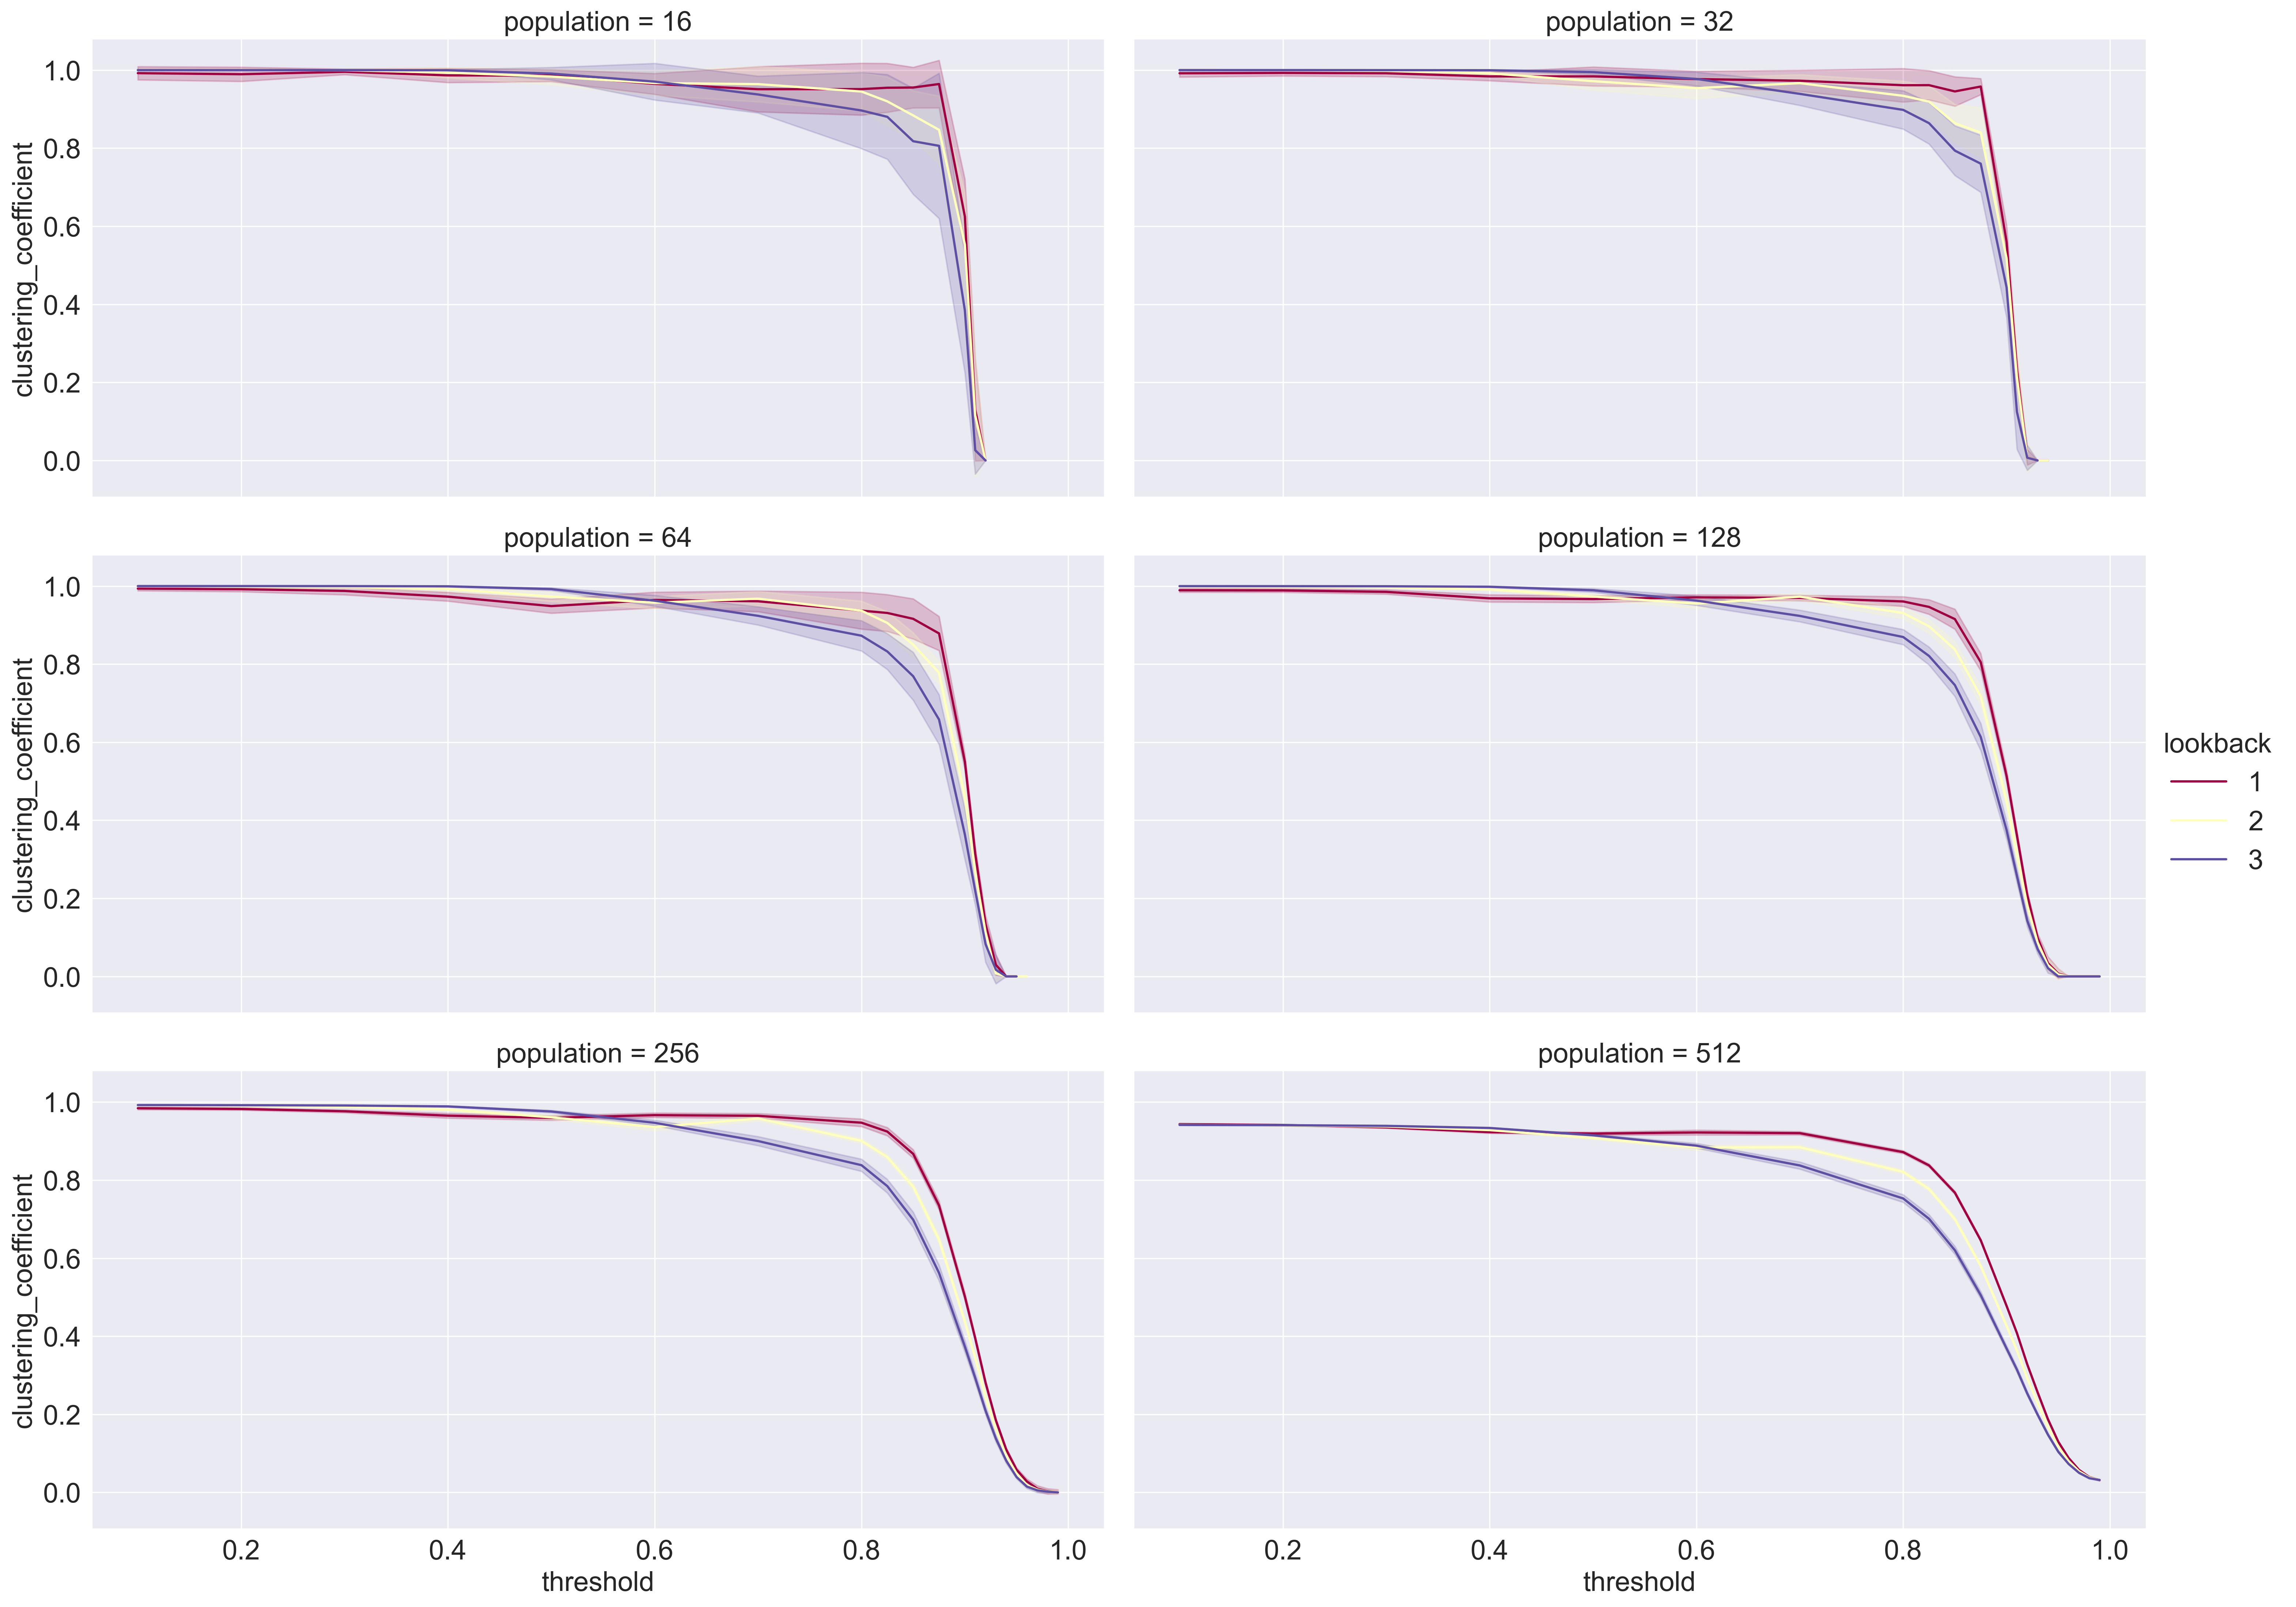

In [6]:
sns.set_style("darkgrid")
sns.relplot(
    data=df,
    x="threshold",
    y="clustering_coefficient",
    hue="lookback",
    col="population",
    col_wrap=2,
    kind="line",
    aspect=2,
    palette="Spectral",
    errorbar="sd",
)

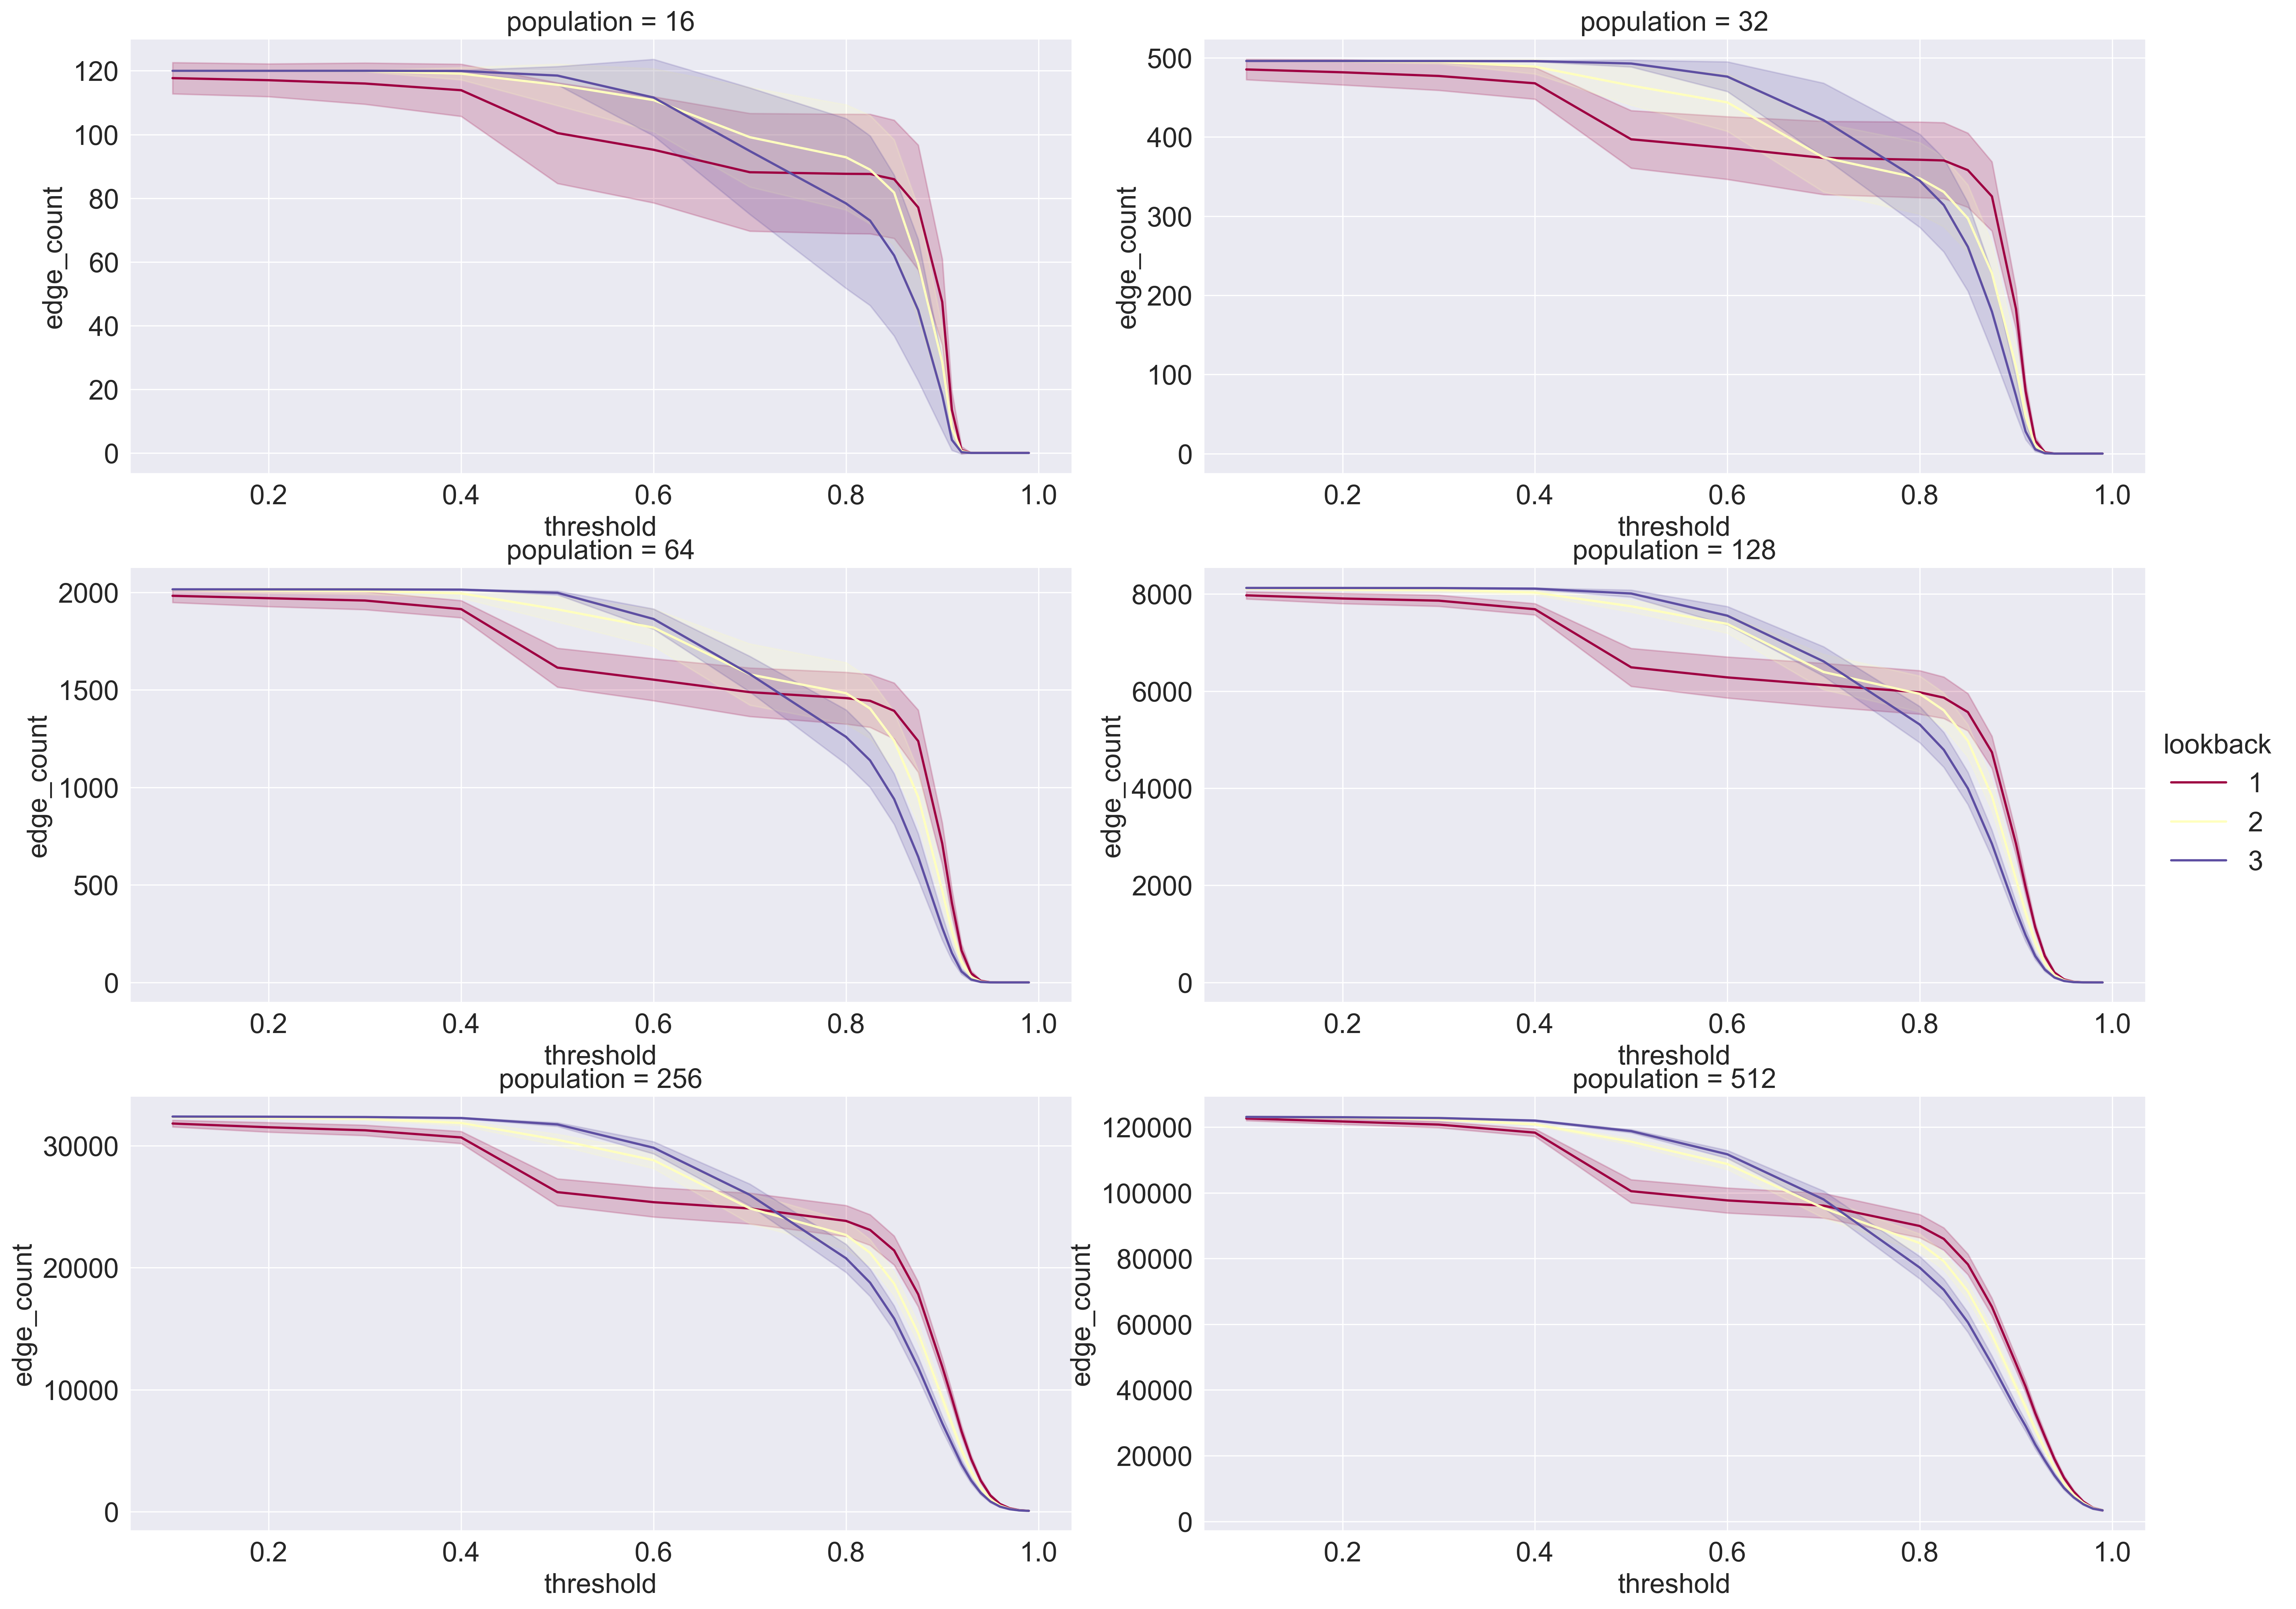

In [7]:
sns.set_style("darkgrid")
sns.relplot(
    data=df,
    x="threshold",
    y="edge_count",
    hue="lookback",
    col="population",
    col_wrap=2,
    kind="line",
    aspect=2,
    palette="Spectral",
    facet_kws={"sharey": False, "sharex": False},
    errorbar="sd",
)

In [8]:
agg_df = (
    df[df["threshold"] == 0.9]
    .groupby(["population", "lookback", "threshold"])
    .agg(
        {
            "clustering_coefficient": ["mean", "std"],
        }
    )
    .round(3)
)

agg_df

clustering_coefficient       
                                                mean    std
population lookback threshold                              
16         1        0.9                        0.625  0.096
           2        0.9                        0.553  0.133
           3        0.9                        0.384  0.160
32         1        0.9                        0.560  0.042
           2        0.9                        0.518  0.049
           3        0.9                        0.443  0.077
64         1        0.9                        0.550  0.020
           2        0.9                        0.460  0.037
           3        0.9                        0.363  0.064
128        1        0.9                        0.513  0.016
           2        0.9                        0.449  0.018
           3        0.9                        0.375  0.023
256        1        0.9                        0.502  0.010
           2        0.9                        0.438  0.009
           3        0.9                        0.373  0.015
512        1        0.9                        0.478  0.003
           2        0.9                        0.426  0.005
           3        0.9                        0.369  0.007

In [9]:
for population, row in (
    agg_df.reset_index().pivot("population", columns="lookback").iterrows()
):
    print(
        population,
        *(
            f"${mean:.3f} \pm {std:.3f}$"
            for mean, std in zip(
                row["clustering_coefficient"]["mean"],
                row["clustering_coefficient"]["std"],
            )
        ),
        sep="\t&\t",
        end=" \\\\\n",
    )

16	&	$0.625 \pm 0.096$	&	$0.553 \pm 0.133$	&	$0.384 \pm 0.160$ \\
32	&	$0.560 \pm 0.042$	&	$0.518 \pm 0.049$	&	$0.443 \pm 0.077$ \\
64	&	$0.550 \pm 0.020$	&	$0.460 \pm 0.037$	&	$0.363 \pm 0.064$ \\
128	&	$0.513 \pm 0.016$	&	$0.449 \pm 0.018$	&	$0.375 \pm 0.023$ \\
256	&	$0.502 \pm 0.010$	&	$0.438 \pm 0.009$	&	$0.373 \pm 0.015$ \\
512	&	$0.478 \pm 0.003$	&	$0.426 \pm 0.005$	&	$0.369 \pm 0.007$ \\


C:\Users\jerem\AppData\Local\Temp/ipykernel_13732/3056726541.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  for population, row in agg_df.reset_index().pivot("population", columns="lookback").iterrows():
